In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Note from Junpeng Lao
In PyMC3, a discrete latent variable could be very easily expressed as a discrete random variable. PyMC3 will assign this discrete variable with a sampler (usually a Metropolis sampler), while the rest of the (continous) RVs sample with NUTS. However, care must be taken, as the correctness of mixing different sampler is in general not guaranteed. The standard treatment is integrate out the latent variables, as done in Stan.

# Chapter 6 - Latent-mixture models
## 6.1 Exam scores


Exam result consistent of 2 group of students - one group is purely guess and the other with a >.5 accuracy rate

$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \phi \sim \text{Uniform}(0.5, 1) $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

(It is also possible to estimate this model using a EM algorthim.)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [phi_interval__]
>BinaryGibbsMetropolis: [zi]
100%|██████████| 3100/3100 [00:07<00:00, 412.94it/s]
The acceptance probability does not match the target. It is 0.931756676989374, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.920790811829639, but should be close to 0.8. Try to increase the number of tuning steps.


Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


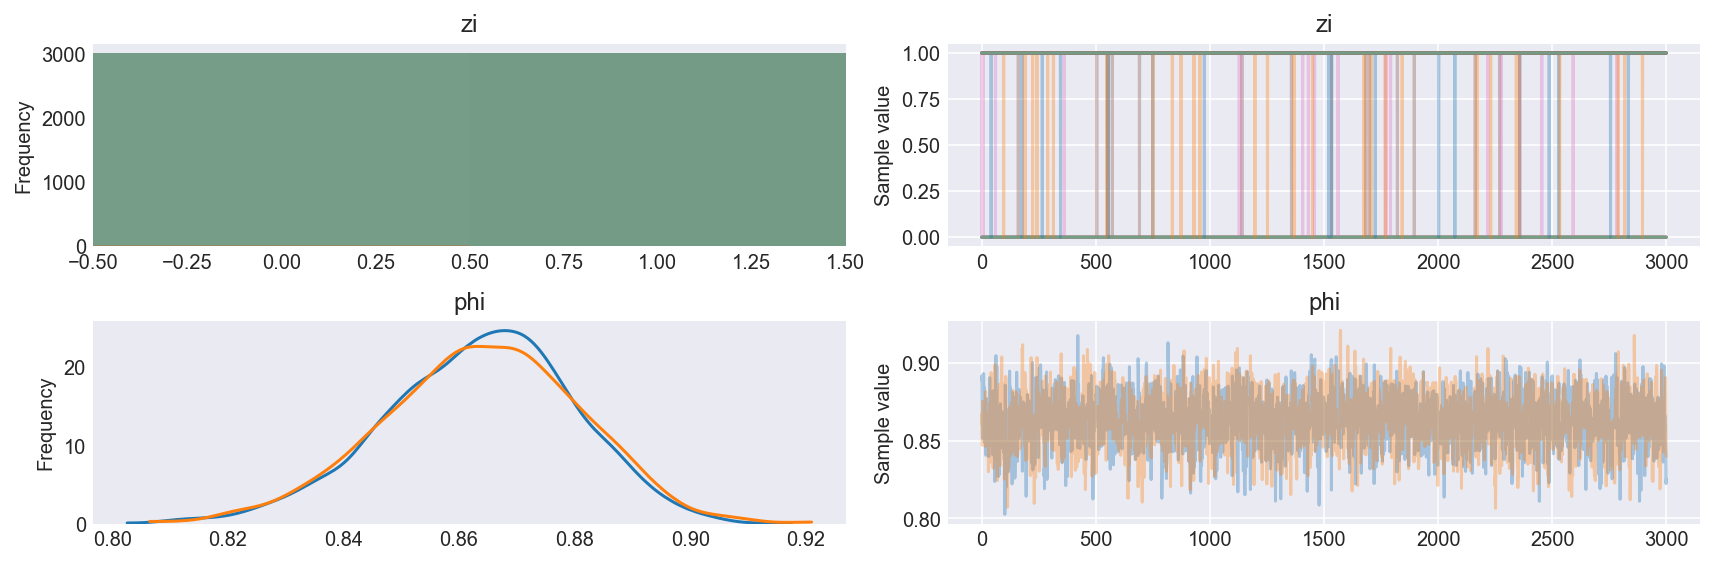

In [2]:
# pymc3
k = np.array([21,17,21,18,22,31,31,34,34,35,35,36,39,36,35])
p = len(k) #number of people
n = 40 # number of questions

with pm.Model() as model1:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    # accuracy prior
    phi = pm.Uniform('phi', upper=1, lower=.5)
    psi = .5
    theta = pm.Deterministic('theta', phi*tt.eq(zi, 1) + psi*tt.eq(zi, 0))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    trace1=pm.sample(3000, tune=100)

pm.traceplot(trace1, ['zi', 'phi']);

ztrace = trace1['zi']
print('Grouping', ztrace[-1, :])

## 6.2 Exam scores with individual differences


$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \mu \sim \text{Uniform}(0.5, 1) $$
$$ \lambda \sim \text{Gamma}(.001, .001)$$  
$$ \phi_{i} \sim \text{Gaussian}(\mu, \lambda)_{\mathcal I(0,1)} $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi_{i}  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [phi_interval__, lambda__log__, mu_interval__]
>BinaryGibbsMetropolis: [zi]
100%|██████████| 4000/4000 [00:36<00:00, 110.32it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


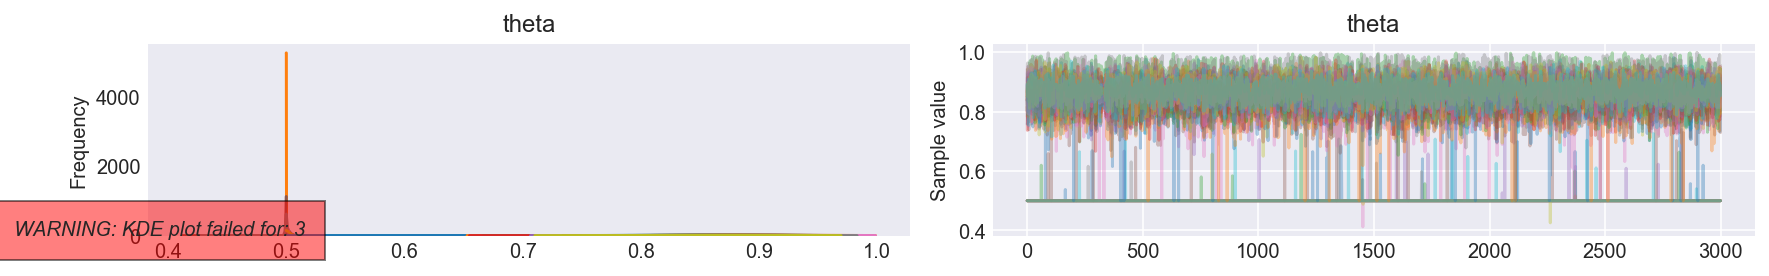

In [3]:
# pymc3 - need some tuning to get the same result as in JAGS
k = np.array([21,17,21,18,22,31,31,34,34,35,35,36,39,36,35])
p = len(k) #number of people
n = 40 # number of questions

with pm.Model() as model2:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    # accuracy prior
    psi = .5
    mu = pm.Uniform('mu', upper=1, lower=.5)
    lambda_ = pm.Gamma('lambda_', alpha=.001, beta=.001)
    phi = pm.Bound(pm.Normal, 0, 1)('phi', mu=mu, tau=lambda_, shape=p)
    
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 1), phi, psi))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    trace2=pm.sample(3000, cores=2, tune=1000)

pm.traceplot(trace2, ['theta']);

ztrace = trace2['zi']
print('Grouping', ztrace[-1, :])

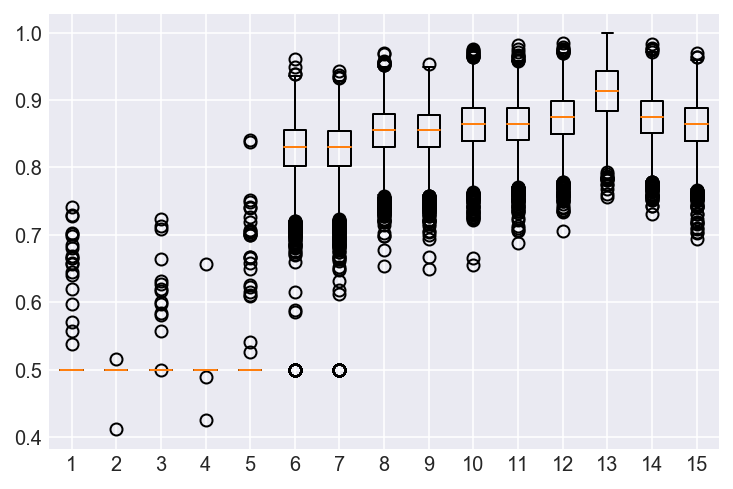

In [4]:
plt.figure()
thetapost = trace2['theta']
plt.boxplot(thetapost);

## 6.3 Twenty questions


Suppose a group of 10 people attend a lecture, and are asked a set of 20 questions afterwards, with every answer being either correct or incorrect.  
$$ p_{i},q_{j} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = p_{i}q_{j} $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [qi_logodds__, pi_logodds__]
>BinaryGibbsMetropolis: [kij_missing]
100%|██████████| 4000/4000 [00:18<00:00, 217.22it/s]


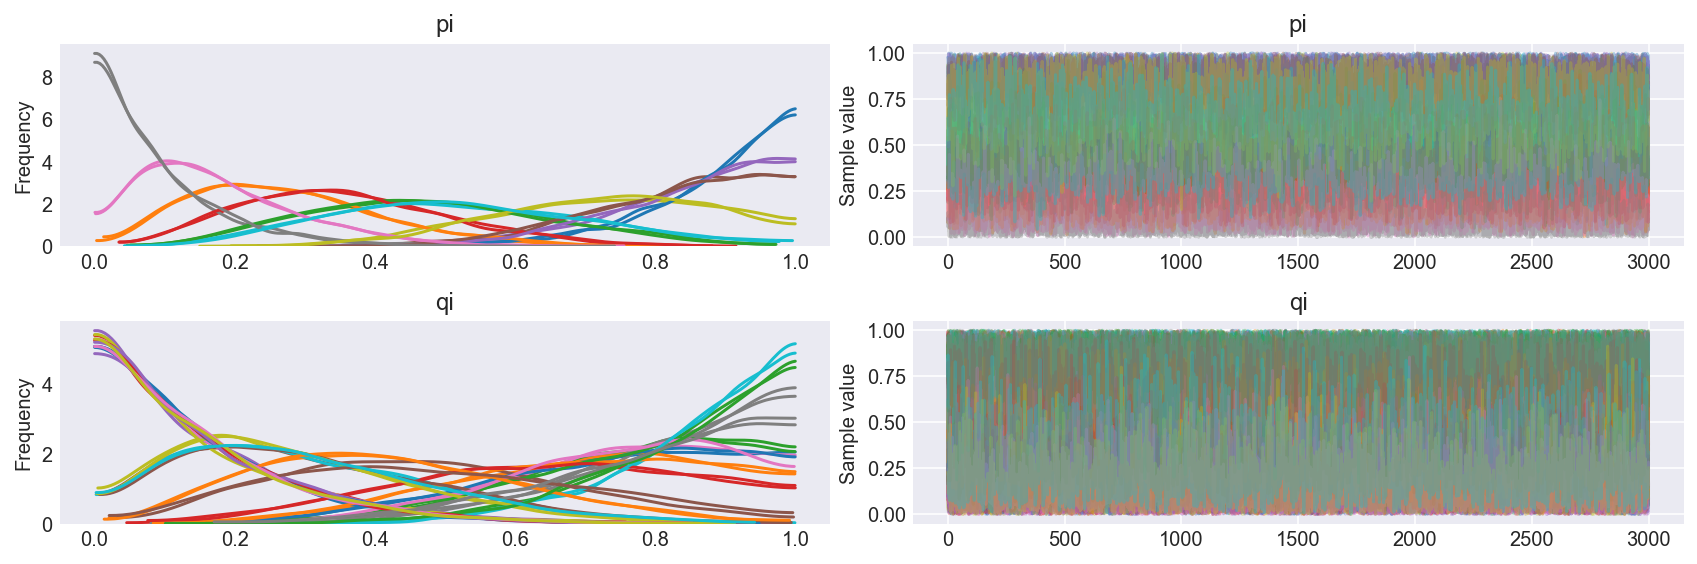

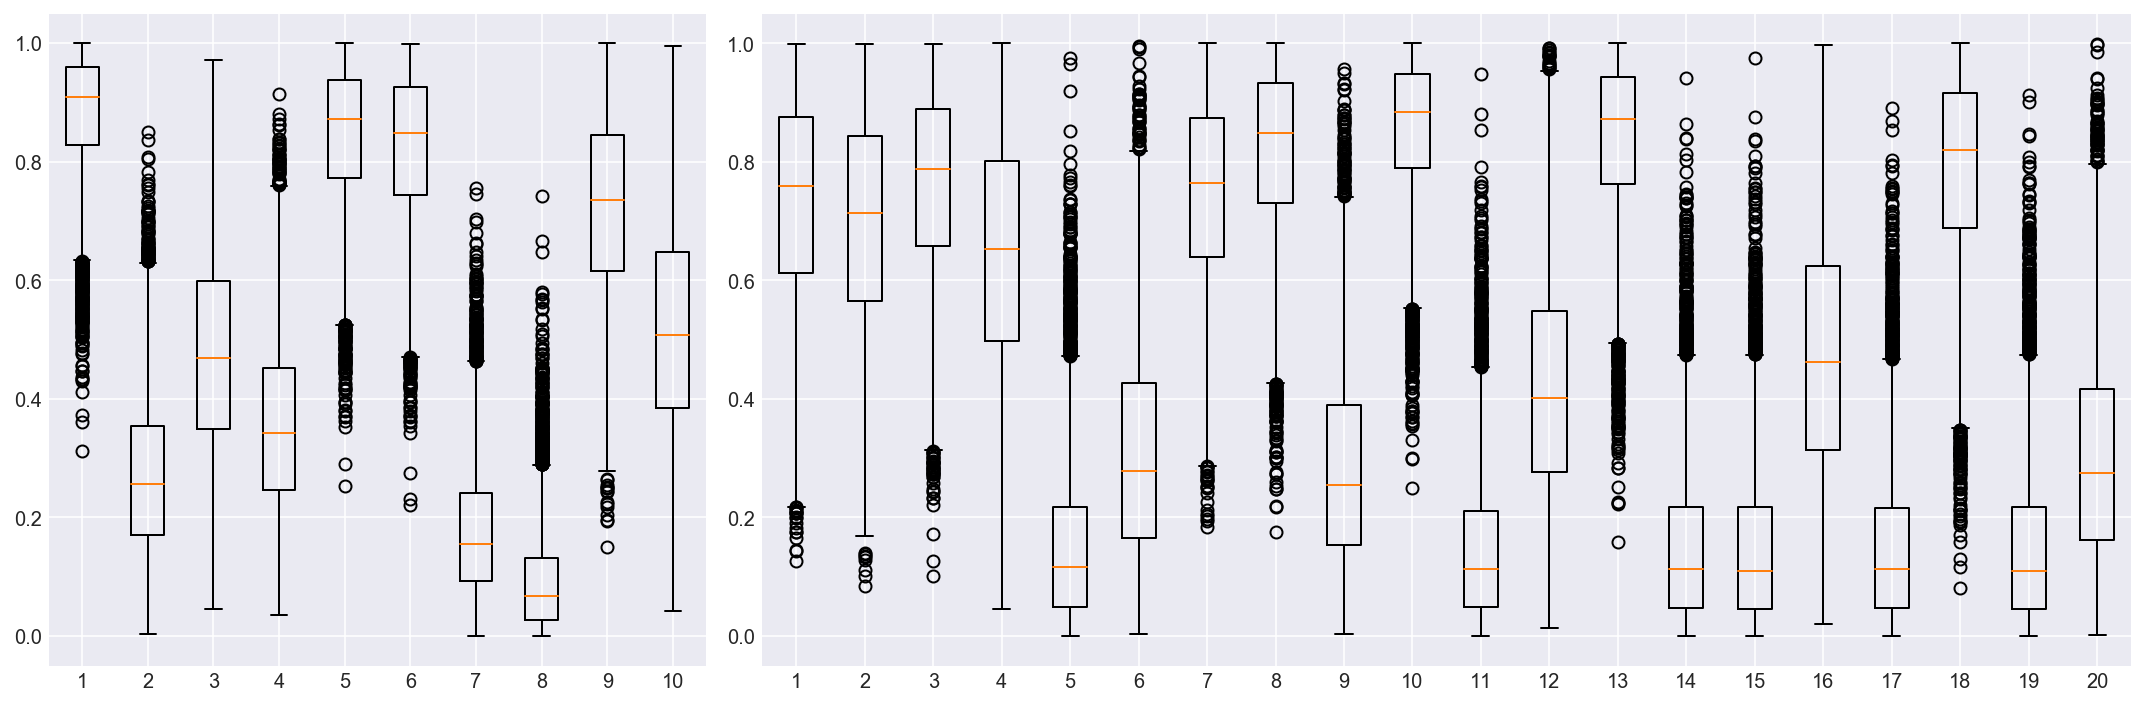

In [5]:
dset = 2
if dset==1:
    k = np.array([1,1,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0]).reshape(10,-1)
elif dset==2:
    k = np.ma.masked_values([1,1,1,1,0,0,1,1,0,1,0,0,-999,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,-999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,-999,0,0], value=-999).reshape(10,-1)
# print(k)
Np, Nq = k.shape

with pm.Model() as model3:
    # prior
    pi = pm.Beta('pi', alpha=1, beta=1, shape=Np)
    qi = pm.Beta('qi', alpha=1, beta=1, shape=Nq)
    # accuracy prior
    theta = pm.Deterministic('theta', tt.outer(pi, qi))
    # observed
    kij = pm.Bernoulli('kij', p=theta, observed=k)
    
    trace3=pm.sample(3000, tune=1000)

pm.traceplot(trace3, ['pi', 'qi']);

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3) 
ax0 = plt.subplot(gs[0])
pipost = trace3['pi']
ax0.boxplot(pipost)

ax1 = plt.subplot(gs[1:])
qipost = trace3['qi']
ax1.boxplot(qipost)

plt.tight_layout();

## 6.4 The two-country quiz


$$ \alpha \sim \text{Uniform}(0,1) $$
$$ \beta \sim \text{Uniform}(0,\alpha) $$
$$ x_{i} \sim \text{Bernoulli}(0.5) $$
$$ z_{j} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\alpha  & \text{if $x_{i} = z_{j}$} \\
\beta  & \text{if $x_{i} \neq z_{j}$}
\end{cases}  $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

In [6]:
dset = 3
if dset==1:
    k = np.array([1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0]).reshape(8,-1)
elif dset==2:
    k = np.ma.masked_values([1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0,
      1,0,0,1,-999,-999,-999,-999,
      0,-999,-999,-999,-999,-999,-999,-999,
      -999,-999,-999,-999,-999,-999,-999,-999], value=-999).reshape(11,-1)
elif dset==3:
    k = np.ma.masked_values([1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0,
      1,0,0,1,-999,-999,-999,-999,
      0,-999,-999,-999,-999,-999,-999,-999,
      -999,-999,-999,-999,-999,-999,-999,-999], value=-999).reshape(21,-1)

Nx, Nz = k.shape

with pm.Model() as model4:
    # prior
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    beta = pm.Uniform('beta', lower=0, upper=alpha)
    
    xi = pm.Bernoulli('xi', p=.5, shape=(Nx, 1))
    zj = pm.Bernoulli('zj', p=.5, shape=(1, Nz))
    
    # accuracy prior
    theta = pm.Deterministic('theta', tt.switch(tt.eq(xi, zj), alpha, beta))
        
    # observed
    kij = pm.Bernoulli('kij', p=theta, observed=k)
    
    step = pm.Slice([alpha, beta])
    trace4 = pm.sample(3000, cores=2, tune=1000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Slice: [alpha_interval__]
>>Slice: [beta_interval__]
>BinaryGibbsMetropolis: [xi, zj, kij_missing]
100%|██████████| 4000/4000 [01:02<00:00, 63.94it/s] 
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


xi [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0]
zj [0 1 1 0 0 1 1 0]


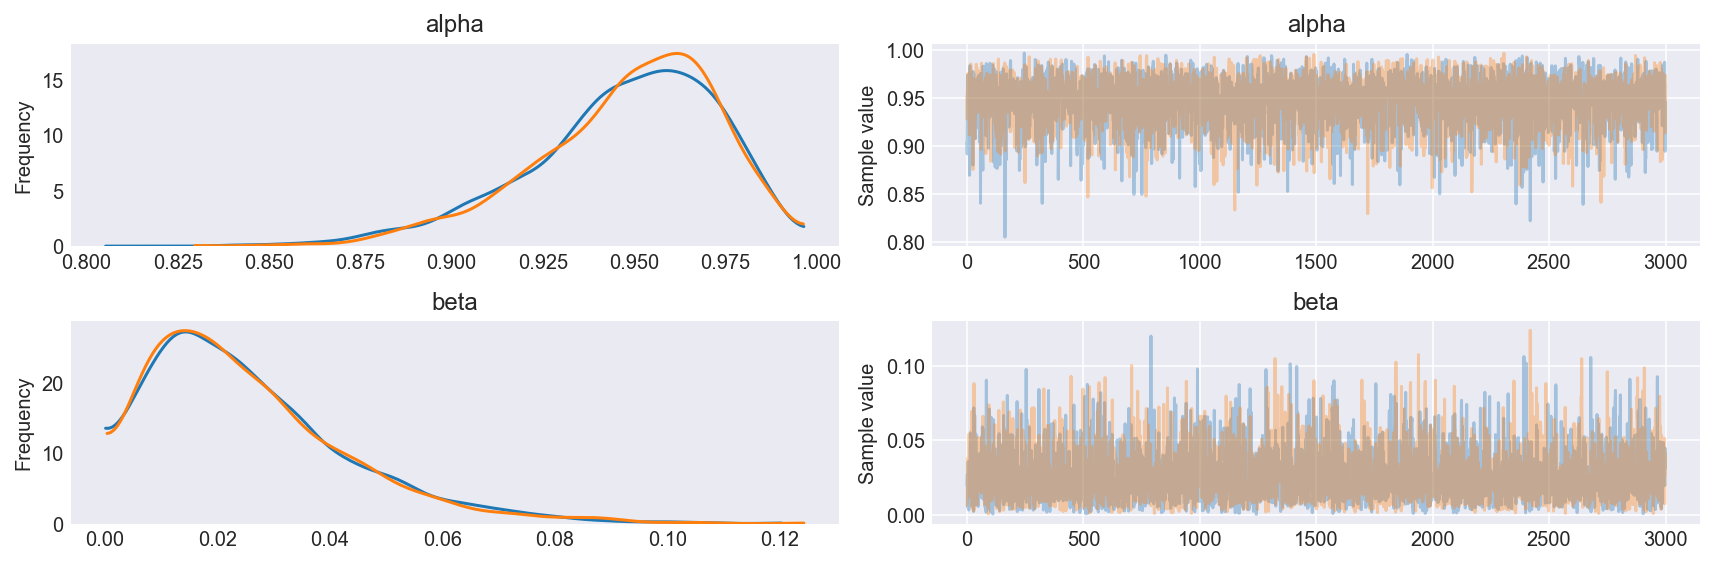

In [7]:
pm.traceplot(trace4, ['alpha', 'beta']);

xtrace = trace4['xi']
print('xi', xtrace[-1, :].flatten())
ztrace = trace4['zj']
print('zj', ztrace[-1, :].flatten())

## 6.5 Assessment of malingering


$$ \psi^b \sim \text{Uniform}(0.5,1) $$
$$ \psi^m \sim \text{Uniform}(0,\psi^b) $$
$$ z_{i} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\psi^b  & \text{if $z_{i} = 0$} \\
\psi^m  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [psim_interval__, psib_interval__]
>BinaryGibbsMetropolis: [zi]
100%|██████████| 3500/3500.0 [00:17<00:00, 204.29it/s]


zi-last [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi-mode [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]


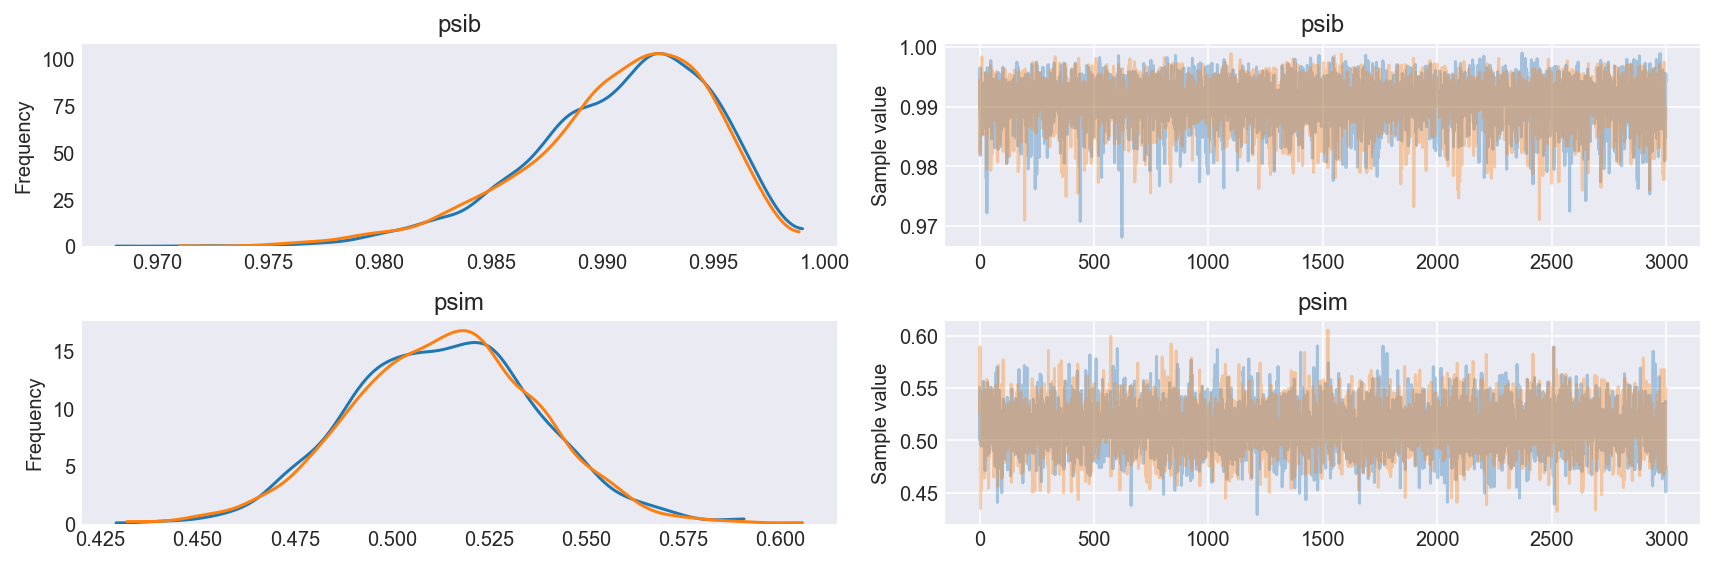

In [8]:
k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30])
p = len(k) # number of people
n = 45        # number of questions

with pm.Model() as model5:
    # prior
    psib = pm.Uniform('psib', lower=0.5, upper=1)
    psim = pm.Uniform('psim', lower=0, upper=psib)
    
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 0), psib, psim))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)
    
    trace5=pm.sample(3e3)

pm.traceplot(trace5, ['psib', 'psim']);

ztrace = trace5['zi']
print('zi-last', ztrace[-1, :])
print('zi-mode', stats.mode(ztrace[:], axis=0).mode.squeeze())

## 6.6 Individual differences in malingering


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(40,800) $$
$$ \lambda_{m} \sim \text{Uniform}(4,100) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{m}\lambda_{m},(1-\mu_{m})\lambda_{m})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{m} = \text{logit}\mu_{b} - \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

In [9]:
k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30])
p = len(k) # number of people
n = 45        # number of questions

with pm.Model() as model6:
    # prior
    mub = pm.Beta('mub', alpha=1, beta=1)
    mud = pm.HalfNormal('mud', sd=.5)
    lambdab = pm.Uniform('lambdab', lower=40, upper=800)
    lambdam = pm.Uniform('lambdam', lower=4, upper=100)
    psi = pm.Beta('psi', alpha=5, beta=5)
    
    zi = pm.Bernoulli('zi', p=psi, shape=p)
    
    mum = pm.Deterministic('mum', 1/(1+tt.exp(tt.log(1/mub-1)+mud)))
    theta1 = pm.Beta('theta1', alpha=mub*lambdab, beta=(1-mub)*lambdab)
    theta2 = pm.Beta('theta2', alpha=mum*lambdam, beta=(1-mum)*lambdam)
    
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 0), theta1, theta2))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)
    trace6 = pm.sample(1e4)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [theta2_logodds__, theta1_logodds__, psi_logodds__, lambdam_interval__, lambdab_interval__, mud_log__, mub_logodds__]
>BinaryGibbsMetropolis: [zi]
100%|██████████| 10500/10500.0 [01:43<00:00, 101.74it/s]


zi-last [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi-mode ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), count=array([[15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000,
        15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000,
        15000, 15000, 14999, 15000]]))


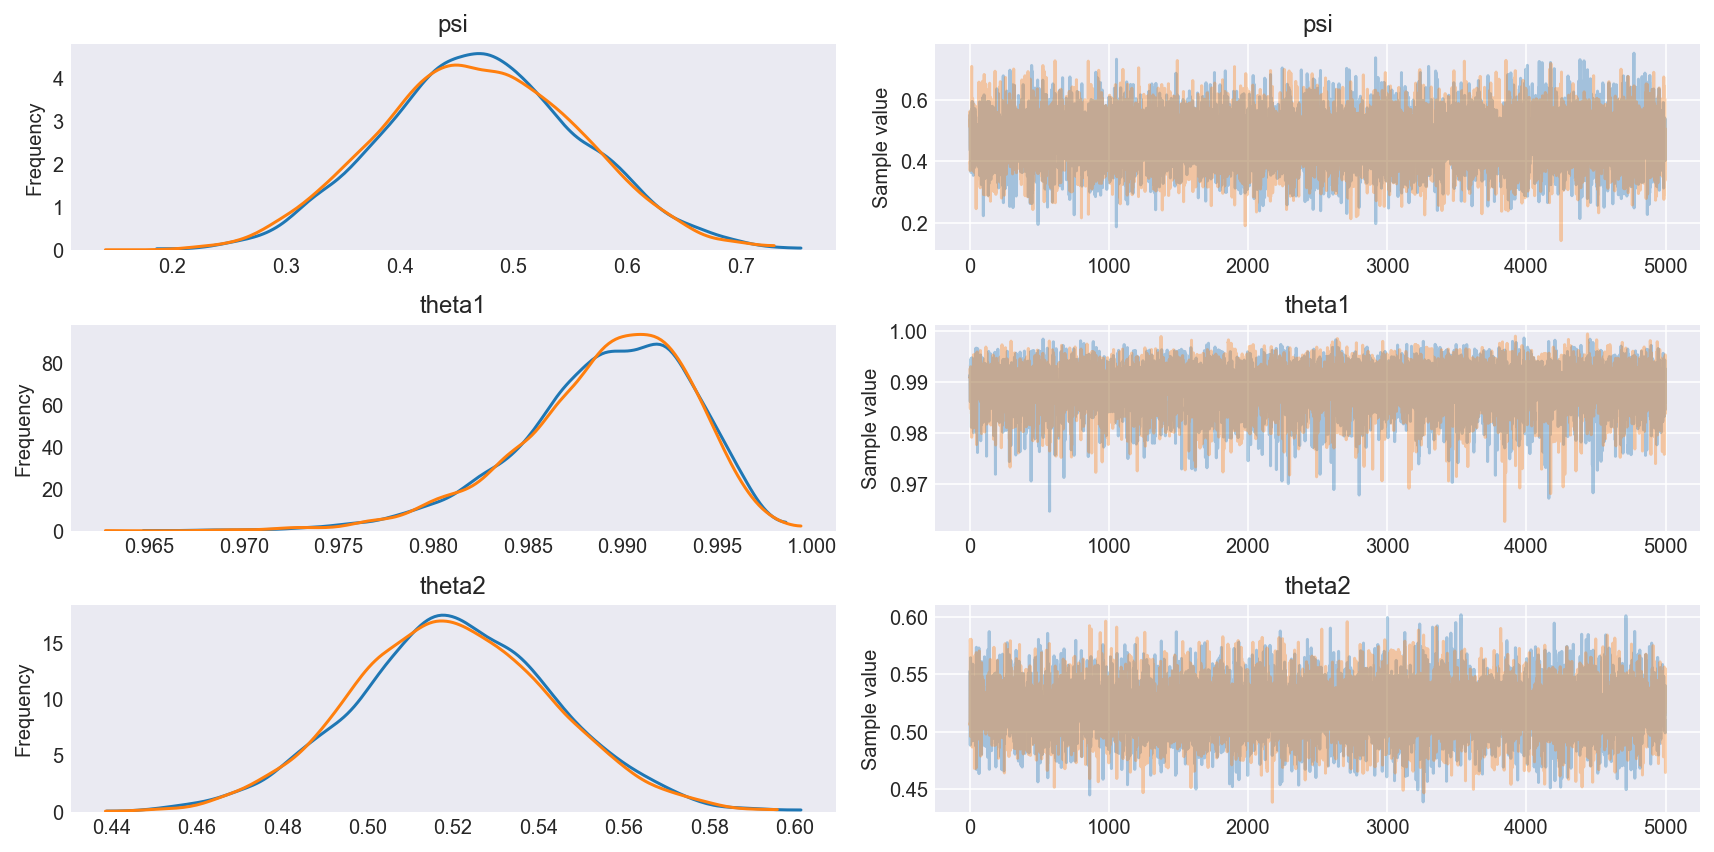

In [10]:
burnin = 5000
pm.traceplot(trace6[burnin:], ['psi', 'theta1', 'theta2']);

ztrace = trace6['zi'][burnin:]
print('zi-last', ztrace[-1, :])
print('zi-mode', stats.mode(ztrace[:], axis=0))

## 6.7 Alzheimer's recall test cheating


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(5,50) $$
$$ \lambda_{c} \sim \text{Uniform}(5,50) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{c}\lambda_{c},(1-\mu_{c})\lambda_{c})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{c} = \text{logit}\mu_{b} + \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

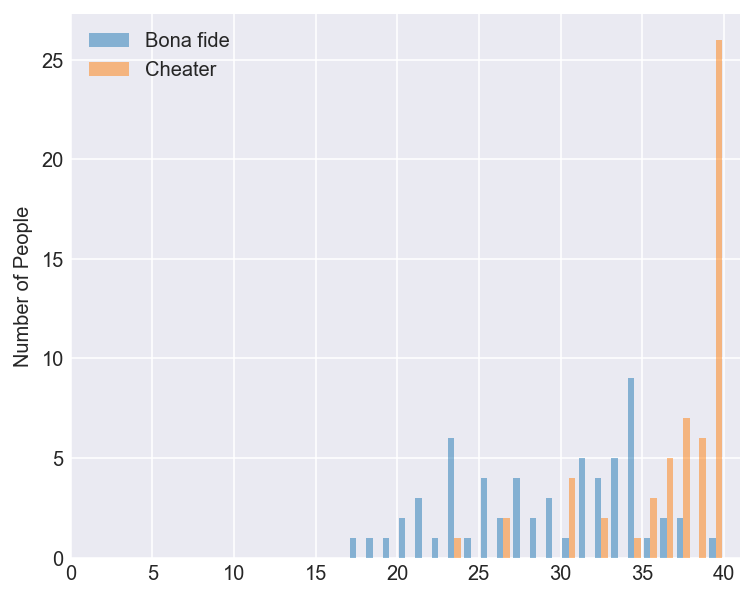

In [11]:
# Load data
dat = pd.read_csv('cheat.csv',header=None)
truth = pd.read_csv('cheatt.csv',header=None)
k = np.array(dat.sum(axis=1))
t1 = truth.values.T

p = len(k) # number of people
n = 40     # number of questions

fig = plt.figure(figsize=(6, 5))
bins = np.arange(0,n+1)
plt.hist([k[t1[0,:]==0],k[t1[0,:]==1]], bins, alpha=0.5, label=['Bona fide','Cheater'])
plt.xlim([0,41])
plt.legend(loc='upper left')
plt.ylabel('Number of People');


In [12]:
with pm.Model() as model7:
    # prior
    mub = pm.Beta('mub', alpha=1, beta=1)
    mud = pm.HalfNormal('mud', sd=.5)
    lambdab = pm.Uniform('lambdab', lower=5, upper=50)
    lambdac = pm.Uniform('lambdac', lower=5, upper=50)
    psi = pm.Beta('psi', alpha=5, beta=5)
    # psi = pm.Uniform("psi",lower=0,upper=1)
    zi = pm.Bernoulli('zi', p=psi, shape=p)
    
    muc = pm.Deterministic('muc', 1/(1+tt.exp(tt.log(1/mub-1)-mud)))
    theta1 = pm.Beta('theta1', alpha=mub*lambdab, beta=(1-mub)*lambdab)
    theta2 = pm.Beta('theta2', alpha=muc*lambdac, beta=(1-muc)*lambdac)
    
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 1), theta1, theta2))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)

logp = -623.74, ||grad|| = 0.076462: 100%|██████████| 51/51 [00:00<00:00, 1682.56it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [theta2_logodds__, theta1_logodds__, psi_logodds__, lambdac_interval__, lambdab_interval__, mud_log__, mub_logodds__]
>BinaryGibbsMetropolis: [zi]
100%|██████████| 3500/3500.0 [01:52<00:00, 21.44it/s]
The number of effective samples is smaller than 25% for some parameters.


zi [0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1
 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1
 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0
 1 0 1 1 1 0 0]
zi ModeResult(mode=array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0]]), count=array([[6000, 6000, 6000, 4532, 5999, 6000, 5957, 5378, 5999, 5887, 6000,
        6000, 6000, 6000, 6000, 6000, 4492, 5997, 5997, 5992, 3747, 5987,
        5995, 5908, 6000, 4557, 6000, 6000, 6000, 6000, 5689, 6000, 5996,
        6000, 5883, 5993, 6000, 4534, 3741, 6000, 5956, 5689, 6000, 5990,
        6000, 6000, 6000, 5995

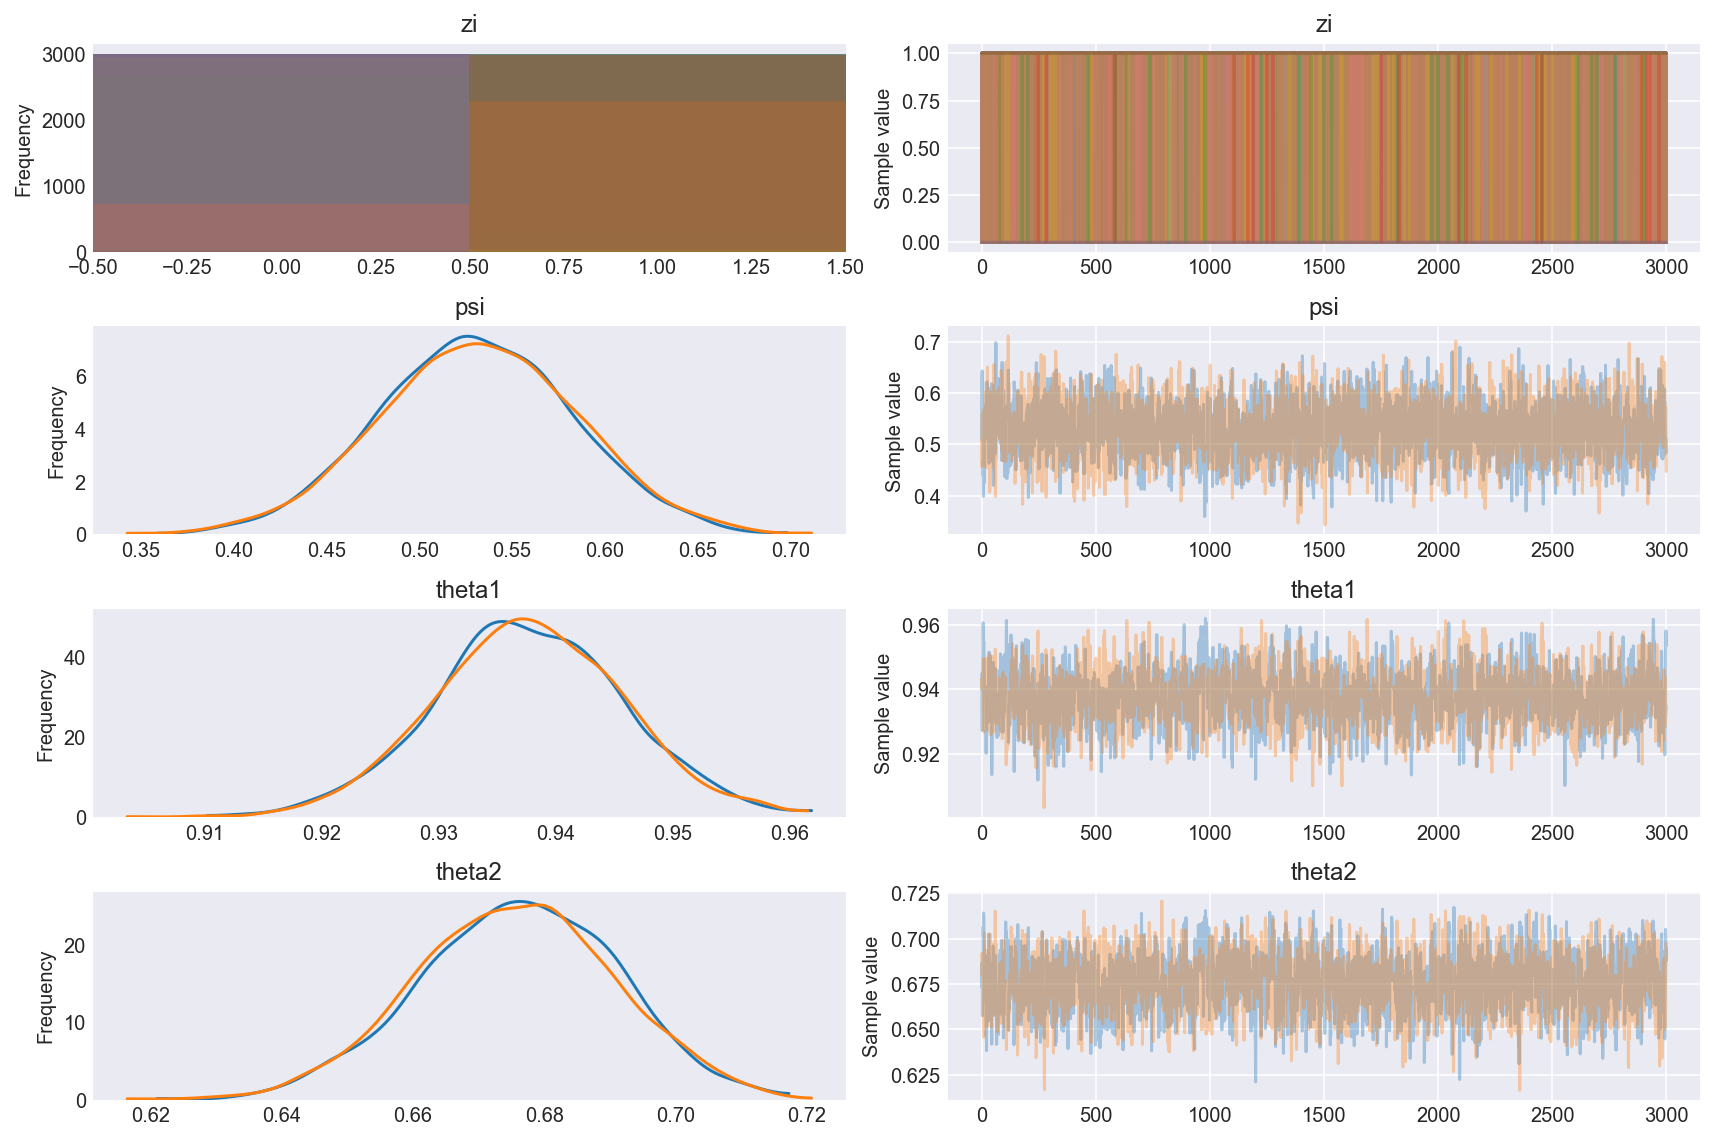

In [13]:
with model7:
    start = pm.find_MAP()
    start['zi']=np.random.binomial(1,.5,p)
    trace7=pm.sample(3e3, start=start, init=None)

burnin=0
pm.traceplot(trace7[burnin:],varnames=['zi','psi','theta1','theta2']);

ztrace = trace7['zi'][burnin:]
print('zi',ztrace[-1,:])
print('zi',stats.mode(ztrace[:],axis=0))
print(np.mean(ztrace[-1:]==(t1[0,:]==1)))

0.8050847457627118


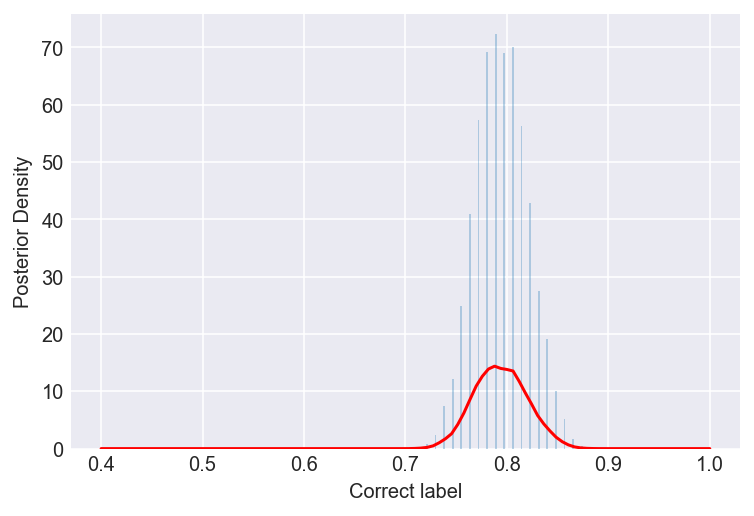

In [16]:
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

ztrace = trace7['zi']

print(np.mean(ztrace[-1:]==(t1[0,:]==1)))
pc=np.mean(ztrace==(t1[0,:]==1),axis=1)

my_pdf = gaussian_kde(pc)
x=np.linspace(.4, 1, 100)
plt.plot(x,my_pdf(x),'r') # distribution function
plt.hist(pc, bins=100, normed=1, alpha=.3)
plt.xlabel('Correct label')
plt.ylabel('Posterior Density');

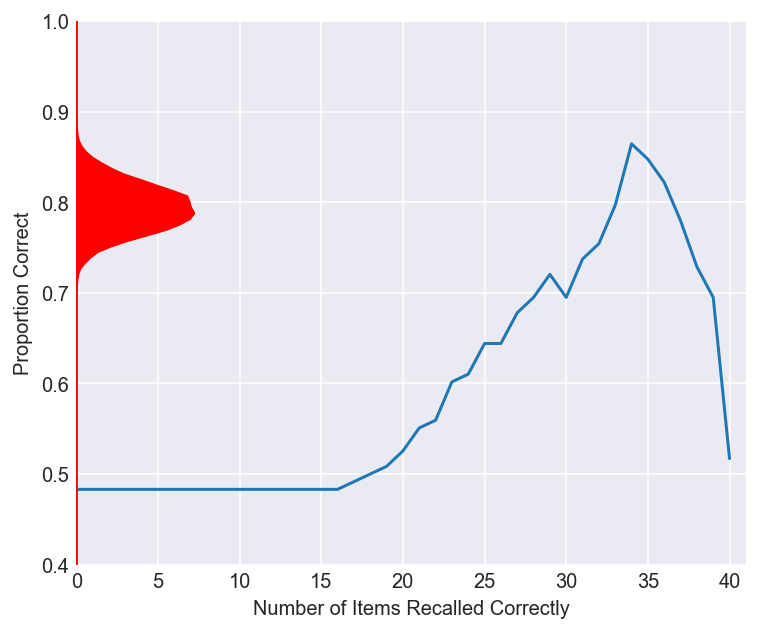

In [17]:
fig = plt.figure(figsize=(6, 5))
my_pdf = gaussian_kde(pc)
x = np.linspace(0.4, 1, 100)
tmp = np.zeros(n+1)
for i in range(n+1):
    tmp[i] = np.mean((k>i)==(t1[0,:]==1))
plt.plot(tmp)
pdfpc=my_pdf(x)/2
plt.plot(pdfpc,x,'r') 
plt.fill_between(pdfpc,x,0,color='r')
plt.axis([0,41,.4,1])
plt.xlabel('Number of Items Recalled Correctly')
plt.ylabel('Proportion Correct');

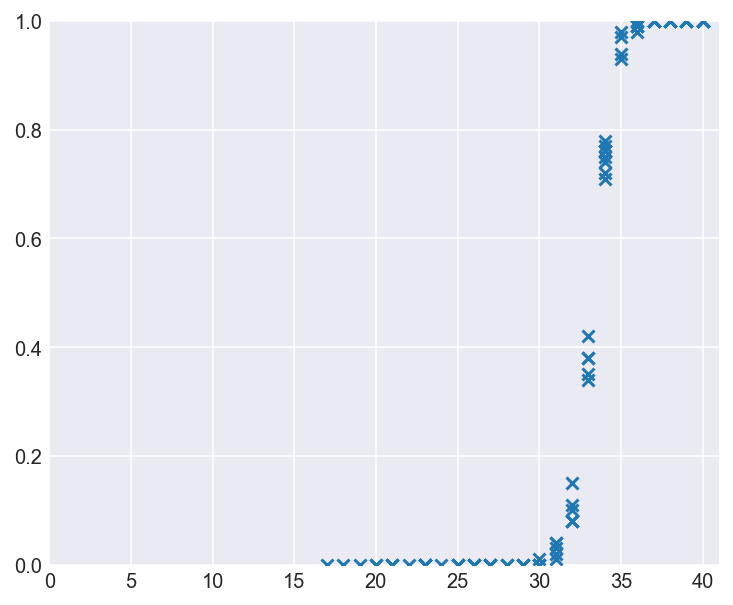

In [18]:
pc2=np.mean(ztrace[0:100],axis=0)
# pc2.shape
plt.figure(figsize=(6, 5))
plt.scatter(k, pc2,marker='x')
plt.axis([0,41,0,1]);